number of molecules being considered: 642


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from bayes_implicit_solvent.constants import beta
def unreduce(value):
    """Input value is in units of kB T, turn it into units of kilocalorie_per_mole"""
    return value / (beta * unit.kilocalorie_per_mole)

from bayes_implicit_solvent.continuous_parameter_experiments.gradient_free import mols as all_mols
# at this stage, let's eliminate any molecule that has an experimental value outside of [-15, +5]
from autograd import numpy as np
mols = []
    
from bayes_implicit_solvent.utils import get_charges
from scipy.spatial.distance import pdist, squareform
from simtk import unit
elements = []
charges = []
distance_matrices = []
expt_means = []
expt_uncs = []
vacuum_trajs = []
for mol in all_mols:
    
    expt_mean = unreduce(mol.experimental_value)
    expt_unc = unreduce(mol.experimental_uncertainty)
    
    if (expt_mean > -15) and (expt_mean < 5):
        
        mols.append(mol)
        expt_means.append(expt_mean)
        expt_uncs.append(expt_unc)

        elements.append(np.array([a.element.atomic_number for a in mol.top.atoms()]))
        charges.append(get_charges(mol.sys))
        distance_matrices.append([squareform(pdist(snapshot / unit.nanometer)) for snapshot in mol.vacuum_traj])
expt_means = np.array(expt_means)
expt_uncs = np.array(expt_uncs)

In [6]:
# THE CODE IN THIS CELL IS ADAPTED FROM https://github.com/HIPS/neural-fingerprint
# ACCOMPANYING "Convolutional Networks on Graphs for Learning Molecular Fingerprints"
# by David Duvenaud, Dougal Maclaurin, Jorge Aguilera-Iparraguirre, Rafael Gómez-Bombarelli, Timothy Hirzel, Alán Aspuru-Guzik, and Ryan P. Adams.

import autograd.numpy as np

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

def atom_features(atom):
    """Use some OpenEye features instead"""
    return np.array(one_of_k_encoding_unk(atom.GetAtomicNum(),
                                      [1, 35, 6, 7, 8, 9, 15, 16, 17, 53, -1]) +
                    one_of_k_encoding(atom.GetDegree(), [1, 2, 3, 4]) +
                    one_of_k_encoding(atom.GetValence(), [1, 2, 3, 4, 5, 6]) +
                    one_of_k_encoding(atom.GetHvyValence(), [0, 1, 2, 3, 4, 5, 6]) +
                    one_of_k_encoding(atom.GetHvyDegree(), [0, 1, 2, 3, 4]) +
                    one_of_k_encoding(atom.GetTotalHCount(), [0, 1, 2, 3, 4]) +
                    [atom.IsAromatic(), atom.IsHalogen(), atom.IsPolarHydrogen(), atom.IsMetal(), atom.IsInRing()] # binary features
                   )
def num_atom_features():
    atoms = list(mols[0].mol.GetAtoms())
    return len(atom_features(atoms[0]))

In [7]:
def compute_features(mol):
    return np.vstack([atom_features(a) for a in mol.GetAtoms()])

computed_features = list(map(compute_features, [mol.mol for mol in mols]))
len(computed_features)

631

In [8]:
N = num_atom_features()
N

43

In [9]:
from autograd.scipy.stats import norm

In [10]:
len(distance_matrices[0])

50

In [11]:
N_atoms = np.array(list(map(len, charges)))

In [12]:
len(mols)

631

In [13]:
n_features = N
n_features

43

In [14]:
default_radius = 0.15
default_scale = 0.8
baseline_bias = np.array([default_radius, default_scale])
baseline_bias

array([0.15, 0.8 ])

In [15]:
def relu(X):
    "Rectified linear activation function."
    return X * (X > 0)

In [16]:
import autograd.numpy.random as npr

class NeuralNet():

    def __init__(self, layer_sizes, scale=0.01):
        assert(layer_sizes[-1] == 2)
        self.layer_sizes = layer_sizes
        self.scale = scale
        self.params = self.init_random_params(scale, layer_sizes)

    def init_random_params(self, scale, layer_sizes, rs=npr.RandomState(0)):
        return [(scale * rs.randn(m, n),  # weight matrix
                 scale * rs.randn(n))  # bias vector
                for m, n in zip(layer_sizes[:-1], layer_sizes[1:])]

    def neural_net_predict(self, params, inputs):
        for W, b in params:
            outputs = np.dot(inputs, W) + b
            inputs = relu(outputs)
        return outputs + baseline_bias

    def __call__(self, inputs):
        return self.neural_net_predict(self.params, inputs)
    
npr.seed(0)
layer_sizes = [n_features, 2]
neural_net = NeuralNet(layer_sizes)

In [17]:
params = neural_net.params

In [18]:
neural_net(computed_features[0])

array([[0.20804834, 0.79478895],
       [0.17475065, 0.79627458],
       [0.16188043, 0.79518197],
       [0.19613242, 0.82061456],
       [0.13902075, 0.77676231],
       [0.12769472, 0.78161642],
       [0.14320772, 0.79528638],
       [0.14320772, 0.79528638],
       [0.13902075, 0.77676231],
       [0.12769472, 0.78161642],
       [0.14320772, 0.79528638],
       [0.14320772, 0.79528638],
       [0.16188043, 0.79518197],
       [0.16188043, 0.79518197],
       [0.16188043, 0.79518197],
       [0.16188043, 0.79518197],
       [0.16188043, 0.79518197]])

In [19]:
from bayes_implicit_solvent.gb_models.numpy_gb_models import compute_OBC_energy_vectorized

In [20]:
radii, scales = neural_net.neural_net_predict(params, computed_features[0]).T
radii, scales

(array([0.20804834, 0.17475065, 0.16188043, 0.19613242, 0.13902075,
        0.12769472, 0.14320772, 0.14320772, 0.13902075, 0.12769472,
        0.14320772, 0.14320772, 0.16188043, 0.16188043, 0.16188043,
        0.16188043, 0.16188043]),
 array([0.79478895, 0.79627458, 0.79518197, 0.82061456, 0.77676231,
        0.78161642, 0.79528638, 0.79528638, 0.77676231, 0.78161642,
        0.79528638, 0.79528638, 0.79518197, 0.79518197, 0.79518197,
        0.79518197, 0.79518197]))

In [21]:
npr.seed(0)
all_inds = np.arange(len(mols))
np.random.shuffle(all_inds)
train_inds = all_inds[::2]
test_inds = all_inds[1::2]


In [22]:
charges[0]

array([-0.1382    ,  0.1522    ,  0.1023    ,  0.1233    , -0.3511    ,
        0.37990001, -0.1655    , -0.1655    , -0.37040001,  0.3845    ,
       -0.1723    , -0.1723    ,  0.0681    ,  0.0681    ,  0.0681    ,
        0.0944    ,  0.0944    ])

In [23]:
from autograd.scipy.misc import logsumexp
from simtk import unit
from bayes_implicit_solvent.constants import kB, temperature

kj_mol_to_kT = 1.0 * unit.kilojoule_per_mole / (kB * temperature)

def one_sided_exp(w_F):
    DeltaF = - (logsumexp(- w_F) - np.log(len(w_F)))
    return DeltaF

In [24]:
all_types = np.array(sorted(list(set([tuple(f) for f in np.vstack(computed_features)]))))
len(all_types)

49

In [25]:
all_types[0]

array([False, False, False, False, False, False, False, False, False,
        True, False,  True, False, False, False,  True, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False,  True, False, False, False])

In [26]:
type_index = dict(zip([tuple(t) for t in all_types], range(len(all_types))))
type_index[tuple(computed_features[0][0])]

35

In [27]:
type_indices = []
for i in range(len(computed_features)):
    type_indices.append(np.array([type_index[tuple(f)] for f in computed_features[i]]))

In [28]:
def make_predictions(params, inds=train_inds, batch_size=5, randomized=True):
    all_radii, all_scales = neural_net.neural_net_predict(params, all_types).T
    
    
    predictions = []
    for i in inds:
        radii, scales= all_radii[type_indices[i]], all_scales[type_indices[i]]
        #radii, scales, log_taus = neural_net.neural_net_predict(params, computed_features[i]).T
        #taus = np.exp(log_taus)
        
        if randomized:
            dmat_inds = np.random.randint(0, len(distance_matrices[i]), batch_size)
        else:
            dmat_inds = np.arange(min(batch_size, len(distance_matrices[i])))
        W_F = np.array([compute_OBC_energy_vectorized(distance_matrices[i][j], radii, scales, charges=charges[i]) for j in dmat_inds])
        
        w_F = W_F * kj_mol_to_kT
        pred_free_energy = unreduce(one_sided_exp(w_F))
        predictions.append(pred_free_energy)
    return np.array(predictions)

In [29]:
predictions = make_predictions(params)

In [30]:
def log_prior(params):
    return - sum([np.linalg.norm(W) + np.linalg.norm(b) for (W,b) in params])
log_prior(params)

-0.10763877806275707

In [31]:
expt_means

array([-4.950e+00, -4.590e+00, -7.400e-01, -9.840e+00, -2.400e+00,
       -6.480e+00,  1.070e+00, -3.430e+00,  1.830e+00, -4.290e+00,
       -3.200e+00, -2.220e+00, -2.370e+00, -7.000e-01, -1.960e+00,
       -2.490e+00, -4.800e-01, -4.220e+00, -4.510e+00, -2.860e+00,
       -6.190e+00, -9.630e+00, -1.620e+00, -2.490e+00, -3.800e+00,
       -2.550e+00, -3.880e+00, -1.460e+00, -9.000e-01, -7.620e+00,
       -1.343e+01, -1.114e+01, -6.400e-01, -1.920e+00,  2.500e-01,
       -3.750e+00, -2.210e+00,  2.670e+00, -4.710e+00, -3.840e+00,
        3.430e+00, -3.780e+00, -6.160e+00, -3.820e+00, -4.590e+00,
       -3.560e+00, -2.810e+00, -5.000e-01, -4.330e+00,  1.160e+00,
       -3.280e+00, -7.800e-01, -3.680e+00, -2.530e+00, -1.101e+01,
       -2.640e+00, -7.980e+00, -7.030e+00, -1.100e+00, -6.120e+00,
       -4.850e+00, -1.160e+00, -2.490e+00, -7.500e+00, -2.480e+00,
       -4.230e+00, -3.810e+00, -2.340e+00, -2.690e+00, -5.220e+00,
       -2.780e+00,  2.880e+00, -3.640e+00, -3.520e+00, -9.820e

In [32]:
predictions

array([ 2.51893830e+00,  6.52409645e-01,  1.94411378e+00, -1.24441321e+00,
        1.23705650e+00, -1.38678078e+01, -1.52081783e+00, -1.56415353e+00,
       -2.02868242e+00, -3.17965936e+00, -4.52874384e+00, -3.12796357e-01,
        8.86823182e-01, -2.73879458e+00, -6.33325948e+00, -1.35129926e+00,
       -3.33247576e-01, -1.51062071e+00, -6.37857467e+00, -7.33866413e+00,
        7.54994923e-01, -7.28309026e+00, -4.10322680e+00, -1.69706483e+01,
        3.27695927e-01,  6.73209847e-01, -1.52927707e+01,  1.50409483e+00,
       -1.97465274e+01,  1.64600894e+00, -8.80045955e+00,  4.77334925e-01,
        3.34902340e+00,  3.87637695e-01, -2.47521778e+00, -3.54404686e-01,
       -8.65102994e+00, -2.34446969e+01, -5.87561857e+00, -2.93479429e-01,
       -2.63249706e-01, -7.36548162e+00, -1.60139026e+00, -1.24279034e+00,
        7.33277266e-01,  3.94079660e-01,  1.37585011e+00, -1.85344761e+00,
       -3.55166002e+00, -2.47491267e+00, -7.31754671e-01,  4.04961411e-01,
       -4.14331017e+00, -

In [33]:
from autograd.scipy.stats import t as student_t

def log_likelihood(params):
    predictions = make_predictions(params)
    return np.sum(student_t.logpdf(predictions, loc=expt_means[train_inds], scale=expt_uncs[train_inds], df=7))

In [34]:
def log_posterior(params):
    return log_prior(params) + log_likelihood(params)

In [35]:
log_posterior(params)

-2171.1134610602717

In [36]:
from autograd import grad
g = grad(log_posterior)(params)

In [37]:
def rmse(x, y):
    squared_errors = (x - y)**2
    mean_squared_errors = np.mean(squared_errors)
    root_mean_squared_errors = np.sqrt(mean_squared_errors)
    return root_mean_squared_errors

In [39]:
from autograd.misc.optimizers import adam, sgd

def loss(x):
    return - log_posterior(x)

def grad_loss(x, i):
    return grad(loss)(x)


traj = [(params, -1, grad_loss(params, -1))]
prediction_traj = [make_predictions(params, inds=np.arange(len(mols)))]
train_rmse = rmse(prediction_traj[-1][train_inds], expt_means[train_inds])
test_rmse = rmse(prediction_traj[-1][test_inds], expt_means[test_inds])
print('initial parameters\n\ttrain RMSE = {:.3f}\n\ttest RMSE = {:.3f}'.format(train_rmse, test_rmse))

def callback(x,i,g):
    #if np.sum(np.isnan(x)) > 0:
    #    raise(RuntimeError('NaNs encountered!'))
    prediction_traj.append(make_predictions(x, inds=np.arange(len(mols)), batch_size=50, randomized=False))
    train_rmse = rmse(prediction_traj[-1][train_inds], expt_means[train_inds])
    test_rmse = rmse(prediction_traj[-1][test_inds], expt_means[test_inds])
    print('Iteration {}\n\ttrain RMSE = {:.3f}\n\ttest RMSE = {:.3f}'.format(i, train_rmse, test_rmse))
    traj.append((x,i,g))
result = adam(grad_loss, params, callback=callback, num_iters=500)

initial parameters
	train RMSE = 3.632
	test RMSE = 3.295
Iteration 0
	train RMSE = 3.695
	test RMSE = 3.414
Iteration 1
	train RMSE = 3.328
	test RMSE = 3.119
Iteration 2
	train RMSE = 3.199
	test RMSE = 3.019
Iteration 3
	train RMSE = 3.099
	test RMSE = 2.856
Iteration 4
	train RMSE = 3.127
	test RMSE = 2.738
Iteration 5
	train RMSE = 3.343
	test RMSE = 2.797
Iteration 6
	train RMSE = 3.214
	test RMSE = 2.694
Iteration 7
	train RMSE = 2.967
	test RMSE = 2.560
Iteration 8
	train RMSE = 2.799
	test RMSE = 2.510
Iteration 9
	train RMSE = 2.696
	test RMSE = 2.521
Iteration 10
	train RMSE = 2.649
	test RMSE = 2.547
Iteration 11
	train RMSE = 2.620
	test RMSE = 2.524
Iteration 12
	train RMSE = 2.643
	test RMSE = 2.500
Iteration 13
	train RMSE = 2.633
	test RMSE = 2.510
Iteration 14
	train RMSE = 2.569
	test RMSE = 2.516
Iteration 15
	train RMSE = 2.540
	test RMSE = 2.521
Iteration 16
	train RMSE = 2.516
	test RMSE = 2.521
Iteration 17
	train RMSE = 2.505
	test RMSE = 2.501
Iteration 18
	tr

Iteration 156
	train RMSE = 1.688
	test RMSE = 1.506
Iteration 157
	train RMSE = 1.693
	test RMSE = 1.481
Iteration 158
	train RMSE = 1.721
	test RMSE = 1.478
Iteration 159
	train RMSE = 1.749
	test RMSE = 1.499
Iteration 160
	train RMSE = 1.735
	test RMSE = 1.492
Iteration 161
	train RMSE = 1.707
	test RMSE = 1.488
Iteration 162
	train RMSE = 1.696
	test RMSE = 1.508
Iteration 163
	train RMSE = 1.674
	test RMSE = 1.499
Iteration 164
	train RMSE = 1.644
	test RMSE = 1.478
Iteration 165
	train RMSE = 1.631
	test RMSE = 1.472
Iteration 166
	train RMSE = 1.627
	test RMSE = 1.484
Iteration 167
	train RMSE = 1.632
	test RMSE = 1.496
Iteration 168
	train RMSE = 1.646
	test RMSE = 1.521
Iteration 169
	train RMSE = 1.670
	test RMSE = 1.537
Iteration 170
	train RMSE = 1.707
	test RMSE = 1.538
Iteration 171
	train RMSE = 1.730
	test RMSE = 1.551
Iteration 172
	train RMSE = 1.752
	test RMSE = 1.578
Iteration 173
	train RMSE = 1.754
	test RMSE = 1.571
Iteration 174
	train RMSE = 1.743
	test RMSE =

KeyboardInterrupt: 

In [40]:
np.savez('linear_typing_result_student_t_loss_df=7.npz',
         prediction_traj=prediction_traj,
         train_inds=train_inds,
         test_inds=test_inds,
         expt_means=expt_means,
         expt_uncs=expt_uncs,
         traj=traj,
         layer_sizes=layer_sizes,
        )

In [41]:
train_rmses = [rmse(snapshot[train_inds], expt_means[train_inds]) for snapshot in prediction_traj]
test_rmses = [rmse(snapshot[test_inds], expt_means[test_inds]) for snapshot in prediction_traj]

In [42]:
train_color = 'lightblue'
test_color = 'green'
train_style = '--'
test_style = '-'

Text(0.5, 0, 'adam iterations')

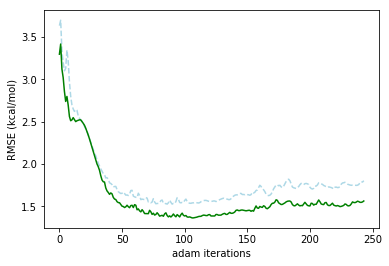

In [43]:
plt.plot(train_rmses, c=train_color, linestyle=train_style)
plt.plot(test_rmses, c=test_color, linestyle=test_style)
plt.ylabel('RMSE (kcal/mol)')
plt.xlabel('adam iterations')

In [44]:
minval, maxval = np.min(prediction_traj[50:]), np.max(prediction_traj[50:])
minval, maxval

(-25.757173958164927, 4.985307878846929)

In [45]:
minval, maxval = -15.5, 5.5
minval, maxval

(-15.5, 5.5)

In [46]:
np.min(expt_means), np.max(expt_means)

(-14.21, 3.4300000000000006)

In [47]:
# color by group?

In [48]:
train_color = 'lightblue'
test_color = 'green'
train_style = '--'
test_style = '-'

In [49]:
inputs = np.vstack(computed_features)
inputs.shape

(11433, 43)

In [50]:
list(set(inputs[:,-1]))

[False, True]

In [51]:
s = 10

In [52]:
from bayes_implicit_solvent.utils import remove_top_right_spines
diag = np.arange(minval, maxval)

for t in range(len(prediction_traj)):
    plt.figure(figsize=(6*1.5,3*1.5))
    ax = plt.subplot(1,2,1)
    remove_top_right_spines(ax)
    
    plt.plot(train_rmses[:t], c=train_color, linestyle=train_style, label='train (n={})'.format(len(train_inds)))
    plt.plot(test_rmses[:t], c=test_color, linestyle=test_style, label='test (n={})'.format(len(test_inds)))
    plt.hlines(2.425900278028874, 0, len(train_rmses), linestyles='-', label='OBC2 (n=631)')
    plt.hlines(1.642, 0, len(train_rmses), linestyles='--', label='SMIRNOFF+TIP3P (n=642)')
    plt.hlines(0.98, 0, len(train_rmses), linestyles='dotted', label='OPLS3e (n=418)')
    
    
    plt.ylabel('RMSE (kcal/mol)')
    plt.xlabel('adam iterations')
    plt.legend(loc='upper right')
    
    plt.xlim(0, len(train_rmses))
    plt.ylim(0, 4)
    
    plt.title('RMSE trace')
    
    ax = plt.subplot(1,2,2)
    remove_top_right_spines(ax)
    
    plt.plot(diag, diag, linestyle='--', c='grey')
    plt.scatter(prediction_traj[t][train_inds], expt_means[train_inds], c=train_color, alpha=0.8, s=s)
    plt.scatter(prediction_traj[t][test_inds], expt_means[test_inds], c=test_color, alpha=0.8, s=s)
    plt.xlim(minval, maxval)
    plt.ylim(minval, maxval)
    
    plt.xticks([-15,-10,-5,0,5])
    plt.yticks([-15,-10,-5,0,5])
    
    plt.xlabel(r'predicted $\Delta G$ (kcal/mol)')
    plt.ylabel(r'measured $\Delta G$ (kcal/mol)')
    
    plt.title('train RMSE: {:.2f}\ntest RMSE: {:.2f}'.format(train_rmses[t], test_rmses[t]))
    plt.tight_layout()
    plt.savefig('linear_parameterizer_student_t_loss/{:04}.png'.format(t), bbox_inches='tight')
    
    plt.close()